In [2]:
try:
    import albumentations as A, einops  # noqa
    print("Albumentations & Einops found ✅")
except Exception:
    !pip install -q albumentations==1.4.11 einops
    import albumentations as A  # noqa

import os, glob, random, math, time
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


Albumentations & Einops found ✅
Using device: cuda


In [4]:
class LGGSegmentationDataset(Dataset):
    """
    Expects the Kaggle LGG dataset directory:
    /kaggle/input/lgg-mri-segmentation/kaggle_3m/<PATIENT>/*.tif (and *_mask.tif)
    Works for .tif or .png/.jpg with *_mask suffix for masks.
    Returns tensors with shape [1, H, W] for both image and mask.
    """
    def __init__(self, root_dir, img_size=256, aug=False):
        self.img_size = int(img_size)
        self.samples = []
        self.aug = aug

        # Supported image extensions (including common variants)
        exts = ("*.tif", "*.png", "*.jpg", "*.jpeg")

        # Collect paired (image, mask) paths
        for patient in sorted(os.listdir(root_dir)):
            pdir = os.path.join(root_dir, patient)
            if not os.path.isdir(pdir):
                continue

            img_files = []
            for e in exts:
                img_files.extend(glob.glob(os.path.join(pdir, e)))

            # Exclude files that are already masks
            img_files = [p for p in img_files if "_mask" not in os.path.basename(p)]
            for img_path in sorted(img_files):
                mask_path = None
                base = os.path.splitext(img_path)[0]
                for me in [
                    base + "_mask.tif",
                    base + "_mask.png",
                    base + "_mask.jpg",
                    base + "_mask.jpeg",
                ]:
                    if os.path.exists(me):
                        mask_path = me
                        break
                if mask_path is not None:
                    self.samples.append((img_path, mask_path))

        print(f"Loaded {len(self.samples)} pairs from {root_dir}")

        # Albumentations pipeline (same transforms applied to image + mask)
        self.train_tf = A.Compose([
            A.Resize(self.img_size, self.img_size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.2),
            A.RandomRotate90(p=0.2),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.3, border_mode=0),
            A.RandomBrightnessContrast(p=0.3),
        ], additional_targets={"mask": "mask"})

        self.val_tf = A.Compose([
            A.Resize(self.img_size, self.img_size),
        ], additional_targets={"mask": "mask"})

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]

        # Load as grayscale image to match original intent
        img = np.array(Image.open(img_path).convert("L"))   # [H, W], 0..255
        mask = np.array(Image.open(mask_path).convert("L")) # [H, W], 0..255

        # Normalize and binarize mask
        mask = (mask > 0).astype(np.float32)

        tf = self.train_tf if self.aug else self.val_tf
        # Albumentations returns a dict with 'image' and 'mask'
        augmented = tf(image=img, mask=mask)
        img_aug = augmented["image"]
        mask_aug = augmented["mask"]

        # Move to channel-first PyTorch tensors
        img_tensor = (img_aug.astype(np.float32) / 255.0)[None, ...]  # [1, H, W]
        mask_tensor = mask_aug.astype(np.float32)[None, ...]           # [1, H, W]

        return torch.from_numpy(img_tensor), torch.from_numpy(mask_tensor)


# --------- Create splits and loaders ---------

DATA_ROOT = os.path.join("/kaggle", "input", "lgg-mri-segmentation", "kaggle_3m")
full_dataset = LGGSegmentationDataset(DATA_ROOT, img_size=256, aug=False)

n_total = len(full_dataset)
n_train = int(0.8 * n_total)
n_val = n_total - n_train

train_subset, val_subset = random_split(full_dataset, [n_train, n_val], generator=torch.Generator().manual_seed(SEED))

# Enable augmentation for training subset
train_subset.dataset.aug = True
val_subset.dataset.aug = False

BATCH_SIZE = 8

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_subset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
print(f"Train: {len(train_subset)} | Val: {len(val_subset)}")

Loaded 3929 pairs from /kaggle/input/lgg-mri-segmentation/kaggle_3m
Train: 3143 | Val: 786


In [6]:
from pathlib import Path
import warnings

# Set a consistent working directory and create output folders
WORK_DIR = Path("/kaggle/working")

# Define all output directories under WORK_DIR
PROCESSED_DATA_DIR = WORK_DIR / "processed" / "lgg"
LOGS_DIR = WORK_DIR / "logs"
CHECKPOINTS_DIR = WORK_DIR / "checkpoints"
VISUALS_DIR = WORK_DIR / "visuals"
METADATA_DIR = WORK_DIR / "metadata"

# Create directories if they don't exist
for d in [PROCESSED_DATA_DIR, LOGS_DIR, CHECKPOINTS_DIR, VISUALS_DIR, METADATA_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Ignore the Albumentations warning (if you still want to suppress it)
warnings.filterwarnings("ignore", category=UserWarning)

In [7]:
# ============================
# 2) Models
# ============================
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1):
        super().__init__()
        self.enc1 = DoubleConv(in_ch, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.pool = nn.MaxPool2d(2)
        self.up1  = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec1 = DoubleConv(256, 128)
        self.up2  = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, out_ch, 1)
    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
        x  = self.up1(x3)
        x  = torch.cat([x, x2], dim=1); x = self.dec1(x)
        x  = self.up2(x)
        x  = torch.cat([x, x1], dim=1); x = self.dec2(x)
        return self.outc(x)  # logits

class AttentionBlock(nn.Module):
    def __init__(self, g_ch, x_ch, int_ch):
        super().__init__()
        self.Wg = nn.Conv2d(g_ch, int_ch, 1)
        self.Wx = nn.Conv2d(x_ch, int_ch, 1)
        self.psi = nn.Conv2d(int_ch, 1, 1)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
    def forward(self, g, x):
        psi = self.relu(self.Wg(g) + self.Wx(x))
        psi = self.sigmoid(self.psi(psi))
        return x * psi

class AttentionUNet(UNet):
    def __init__(self, in_ch=1, out_ch=1):
        super().__init__(in_ch, out_ch)
        self.att1 = AttentionBlock(128, 128, 64)
        self.att2 = AttentionBlock(64, 64, 32)
    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
        g1 = self.up1(x3)
        x2 = self.att1(g1, x2)
        x  = torch.cat([g1, x2], dim=1); x = self.dec1(x)
        g2 = self.up2(x)
        x1 = self.att2(g2, x1)
        x  = torch.cat([g2, x1], dim=1); x = self.dec2(x)
        return self.outc(x)  # logits

class SwinUNet(nn.Module):
    """Tiny CNN-based Swin-UNet stand-in (no transformer deps)"""
    def __init__(self, in_ch=1, out_ch=1, base=64):
        super().__init__()
        self.enc1 = DoubleConv(in_ch, base)
        self.enc2 = DoubleConv(base, base*2)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(base*2, base*4)
        self.up1  = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.dec1 = DoubleConv(base*4, base*2)
        self.up2  = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.dec2 = DoubleConv(base*2, base)
        self.outc = nn.Conv2d(base, out_ch, 1)
    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.bottleneck(self.pool(x2))
        x  = self.up1(x3)
        x  = torch.cat([x, x2], dim=1); x = self.dec1(x)
        x  = self.up2(x)
        x  = torch.cat([x, x1], dim=1); x = self.dec2(x)
        return self.outc(x)  # logits

class MambaBlock(nn.Module):
    """Pure-PyTorch 'sequence mixing' stub"""
    def __init__(self, ch):
        super().__init__()
        self.fc1 = nn.Conv2d(ch, ch, 1)
        self.fc2 = nn.Conv2d(ch, ch, 1)
        self.act = nn.GELU()
        self.bn  = nn.BatchNorm2d(ch)
    def forward(self, x):
        skip = x
        x = self.bn(self.act(self.fc1(x)))
        x = self.fc2(x)
        return x + skip

class MambaUNet(UNet):
    def __init__(self, in_ch=1, out_ch=1):
        super().__init__(in_ch, out_ch)
        self.m1 = MambaBlock(64); self.m2 = MambaBlock(128); self.m3 = MambaBlock(256)
    def forward(self, x):
        x1 = self.m1(self.enc1(x))
        x2 = self.m2(self.enc2(self.pool(x1)))
        x3 = self.m3(self.enc3(self.pool(x2)))
        x  = self.up1(x3)
        x  = torch.cat([x, x2], dim=1); x = self.dec1(x)
        x  = self.up2(x)
        x  = torch.cat([x, x1], dim=1); x = self.dec2(x)
        return self.outc(x)  # logits

In [10]:
# ============================  
# 3) Losses & Metrics  
# ============================  
def dice_coef(pred, target, eps=1e-6):  
    # pred, target in {0,1}; shapes [N,1,H,W]  
    inter = (pred * target).sum(dim=(2,3))  
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))  
    dice = (2*inter + eps) / (union + eps)  
    return dice.mean().item()  

def iou_score(pred, target, eps=1e-6):  
    inter = (pred * target).sum(dim=(2,3))  
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) - inter  
    iou = (inter + eps) / (union + eps)  
    return iou.mean().item()  

class DiceLoss(nn.Module):  
    def __init__(self, eps=1e-6): super().__init__(); self.eps=eps  
    def forward(self, logits, targets):  
        probs = torch.sigmoid(logits)  
        num = 2*(probs*targets).sum(dim=(2,3)) + self.eps  
        den = probs.sum(dim=(2,3)) + targets.sum(dim=(2,3)) + self.eps  
        return 1 - (num/den).mean()  

def combo_loss(logits, targets, bce_w=0.5):  
    bce = F.binary_cross_entropy_with_logits(logits, targets)  
    dice = DiceLoss()(logits, targets)  
    return bce_w*bce + (1-bce_w)*dice  


In [14]:
# ============================  
# 4) Train / Eval Utilities  
# ============================  
def train_one_epoch(model, loader, opt, scaler=None):
    model.train()
    running = 0.0
    for x, y in loader:
        x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
        opt.zero_grad(set_to_none=True)

        if scaler is None:
            # CPU path (no AMP)
            logits = model(x)
            loss = combo_loss(logits, y)
            loss.backward()
            opt.step()
        else:
            # CUDA + AMP path using new API
            with torch.amp.autocast("cuda"):
                logits = model(x)
                loss = combo_loss(logits, y)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

        running += loss.item() * x.size(0)
    return running / len(loader.dataset)
@torch.no_grad()  
def evaluate(model, loader, thresh=0.5):  
    model.eval()  
    dices, ious = [], []  
    for x, y in loader:  
        x, y = x.to(DEVICE), y.to(DEVICE)  
        logits = model(x)  
        probs = torch.sigmoid(logits)  
        pred = (probs > thresh).float()  
        dices.append(dice_coef(pred, y))  
        ious.append(iou_score(pred, y))  
    return float(np.mean(ious)), float(np.mean(dices))  



----- Training UNet -----
Epoch 01 | loss 0.5382 | IoU 0.6591 | Dice 0.6591
Epoch 02 | loss 0.4812 | IoU 0.5660 | Dice 0.5858

----- Training AttentionUNet -----
Epoch 01 | loss 0.5115 | IoU 0.5339 | Dice 0.5608
Epoch 02 | loss 0.4775 | IoU 0.5330 | Dice 0.5539

----- Training SwinUNet -----
Epoch 01 | loss 0.5176 | IoU 0.6005 | Dice 0.6189
Epoch 02 | loss 0.4840 | IoU 0.4024 | Dice 0.4297

----- Training MambaUNet -----
Epoch 01 | loss 0.5147 | IoU 0.2935 | Dice 0.3223
Epoch 02 | loss 0.4748 | IoU 0.5176 | Dice 0.5467

=== Validation Results (higher is better) ===
           Model       IoU      Dice
0           UNet  0.659091  0.659091
1       SwinUNet  0.600515  0.618906
2  AttentionUNet  0.533945  0.560799
3      MambaUNet  0.517584  0.546729


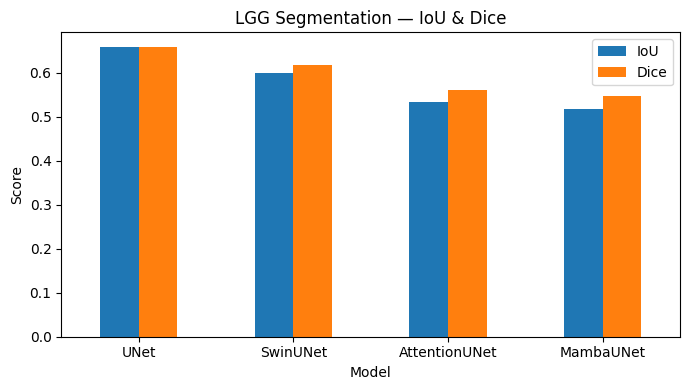

In [15]:
# ============================
# 5) Run Experiments (AMP updated)
# ============================
EPOCHS = 2          # keep small for quick runs; increase for better scores
LR = 1e-3
MODELS = {
    "UNet": UNet(),
    "AttentionUNet": AttentionUNet(),
    "SwinUNet": SwinUNet(),
    "MambaUNet": MambaUNet(),
}

results = []
for name, net in MODELS.items():
    print(f"\n----- Training {name} -----")
    net = net.to(DEVICE)
    opt = torch.optim.AdamW(net.parameters(), lr=LR, weight_decay=1e-4)

    # New AMP API usage
    scaler = torch.amp.GradScaler() if DEVICE == "cuda" else None

    best_val = -1
    best_ckpt = None
    for e in range(1, EPOCHS + 1):
        # Use new autocast inside train_one_epoch if AMP is active
        tr_loss = train_one_epoch(net, train_loader, opt, scaler)
        iou, dice = evaluate(net, val_loader)
        print(f"Epoch {e:02d} | loss {tr_loss:.4f} | IoU {iou:.4f} | Dice {dice:.4f}")
        if dice > best_val:
            best_val = dice
            best_ckpt = {k: v.detach().cpu().clone() for k, v in net.state_dict().items()}

    # load best (by Dice) and re-eval
    if best_ckpt is not None:
        net.load_state_dict(best_ckpt)
    iou, dice = evaluate(net, val_loader)
    results.append({"Model": name, "IoU": iou, "Dice": dice})

# Results table
df = pd.DataFrame(results).sort_values("Dice", ascending=False).reset_index(drop=True)
print("\n=== Validation Results (higher is better) ===")
print(df)

# Optional: bar plot
ax = df.set_index("Model")[["IoU","Dice"]].plot(kind="bar", figsize=(7,4))
ax.set_ylabel("Score"); ax.set_title("LGG Segmentation — IoU & Dice")
plt.xticks(rotation=0); plt.tight_layout(); plt.show()

In [16]:
import os, glob
root="/kaggle/input/lgg-mri-segmentation/kaggle_3m"
pairs=[]
exts=("*.tif","*.png")
for p in sorted(os.listdir(root)):
    d=os.path.join(root,p)
    if not os.path.isdir(d): continue
    files=[]
    for e in exts: files+=glob.glob(os.path.join(d,e))
    files=[f for f in sorted(files) if "_mask" not in os.path.basename(f)]
    for img in files:
        base=os.path.splitext(img)[0]
        for m in (base+"_mask.tif", base+"_mask.png", base+"_mask.jpg"):
            if os.path.exists(m):
                pairs.append((img,m)); break
print("Pairs found:", len(pairs))
print("First 10 pairs:")
for a,b in pairs[:10]:
    print(os.path.basename(a)," <-> ", os.path.basename(b))


Pairs found: 3929
First 10 pairs:
TCGA_CS_4941_19960909_1.tif  <->  TCGA_CS_4941_19960909_1_mask.tif
TCGA_CS_4941_19960909_10.tif  <->  TCGA_CS_4941_19960909_10_mask.tif
TCGA_CS_4941_19960909_11.tif  <->  TCGA_CS_4941_19960909_11_mask.tif
TCGA_CS_4941_19960909_12.tif  <->  TCGA_CS_4941_19960909_12_mask.tif
TCGA_CS_4941_19960909_13.tif  <->  TCGA_CS_4941_19960909_13_mask.tif
TCGA_CS_4941_19960909_14.tif  <->  TCGA_CS_4941_19960909_14_mask.tif
TCGA_CS_4941_19960909_15.tif  <->  TCGA_CS_4941_19960909_15_mask.tif
TCGA_CS_4941_19960909_16.tif  <->  TCGA_CS_4941_19960909_16_mask.tif
TCGA_CS_4941_19960909_17.tif  <->  TCGA_CS_4941_19960909_17_mask.tif
TCGA_CS_4941_19960909_18.tif  <->  TCGA_CS_4941_19960909_18_mask.tif


In [17]:
# Small check: show shapes, value ranges, unique mask values (first 12 pairs)
# and dataset-level counts of empty / tiny masks.
import os, glob
from PIL import Image
import numpy as np

root = "/kaggle/input/lgg-mri-segmentation/kaggle_3m"
exts = ("*.tif","*.png","*.jpg")

pairs = []
for p in sorted(os.listdir(root)):
    pd = os.path.join(root, p)
    if not os.path.isdir(pd): continue
    files = []
    for e in exts: files += glob.glob(os.path.join(pd, e))
    files = sorted([f for f in files if "_mask" not in os.path.basename(f)])
    for img in files:
        base = os.path.splitext(img)[0]
        for m in (base + "_mask.tif", base + "_mask.png", base + "_mask.jpg"):
            if os.path.exists(m):
                pairs.append((img, m)); break

print("Total pairs found:", len(pairs))
print("\nFirst 12 pairs (basename):")
for a,b in pairs[:12]:
    print(os.path.basename(a), "<->", os.path.basename(b))

# Inspect first N pairs for raw stats
N = 12
print("\nPer-file stats (first {}):".format(N))
for img_path, mask_path in pairs[:N]:
    I = np.array(Image.open(img_path).convert("L"))
    M = np.array(Image.open(mask_path).convert("L"))
    uniq = np.unique(M)
    nonzero = (M>0).sum()
    pct = 100.0 * nonzero / M.size
    print(f"{os.path.basename(img_path):40s} shape={I.shape} min/max={I.min()}/{I.max():3d} mean={I.mean():.1f}")
    print(f"  {os.path.basename(mask_path):40s} shape={M.shape} unique_vals_sample={uniq[:10].tolist()}  nonzero_px={nonzero} ({pct:.3f}%)")

# Dataset-level counts (quick)
empty_count = 0
tiny_count = 0
small_count = 0
for i,(img_path, mask_path) in enumerate(pairs):
    M = np.array(Image.open(mask_path).convert("L"))
    nonzero = (M>0).sum()
    if nonzero == 0:
        empty_count += 1
    pct = 100.0 * nonzero / M.size
    if pct < 0.01:     # <0.01% coverage
        tiny_count += 1
    if pct < 1.0:      # <1% coverage
        small_count += 1
    if i >= 2000:      # limit for speed
        break

total_checked = min(len(pairs), 2001)
print(f"\nChecked {total_checked} masks (first {total_checked}):")
print(" Empty masks (0 pixels):", empty_count)
print(" Masks with coverage <0.01%:", tiny_count)
print(" Masks with coverage <1%:", small_count)
print(" Percent empty:", 100.0*empty_count/total_checked, "%")


Total pairs found: 3929

First 12 pairs (basename):
TCGA_CS_4941_19960909_1.tif <-> TCGA_CS_4941_19960909_1_mask.tif
TCGA_CS_4941_19960909_10.tif <-> TCGA_CS_4941_19960909_10_mask.tif
TCGA_CS_4941_19960909_11.tif <-> TCGA_CS_4941_19960909_11_mask.tif
TCGA_CS_4941_19960909_12.tif <-> TCGA_CS_4941_19960909_12_mask.tif
TCGA_CS_4941_19960909_13.tif <-> TCGA_CS_4941_19960909_13_mask.tif
TCGA_CS_4941_19960909_14.tif <-> TCGA_CS_4941_19960909_14_mask.tif
TCGA_CS_4941_19960909_15.tif <-> TCGA_CS_4941_19960909_15_mask.tif
TCGA_CS_4941_19960909_16.tif <-> TCGA_CS_4941_19960909_16_mask.tif
TCGA_CS_4941_19960909_17.tif <-> TCGA_CS_4941_19960909_17_mask.tif
TCGA_CS_4941_19960909_18.tif <-> TCGA_CS_4941_19960909_18_mask.tif
TCGA_CS_4941_19960909_19.tif <-> TCGA_CS_4941_19960909_19_mask.tif
TCGA_CS_4941_19960909_2.tif <-> TCGA_CS_4941_19960909_2_mask.tif

Per-file stats (first 12):
TCGA_CS_4941_19960909_1.tif              shape=(256, 256) min/max=0/158 mean=26.6
  TCGA_CS_4941_19960909_1_mask.tif    

In [18]:
# RUN: shows coverage distribution for train and val splits
import numpy as np, cv2
from tqdm import tqdm

def coverage_list(pairs, nlimit=None):
    cov=[]
    for i,(img,mask) in enumerate(pairs):
        M = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
        if M is None:
            from PIL import Image
            M = np.array(Image.open(mask).convert('L'))
        Msmall = cv2.resize(M, (256,256), interpolation=cv2.INTER_NEAREST)
        cov.append(100.0*(Msmall>0).sum()/Msmall.size)
        if nlimit and i+1>=nlimit: break
    return np.array(cov)

# Build pairs list same as before
import glob, os
root="/kaggle/input/lgg-mri-segmentation/kaggle_3m"
pairs=[]
exts=("*.tif","*.png","*.jpg")
for p in sorted(os.listdir(root)):
    d=os.path.join(root,p)
    if not os.path.isdir(d): continue
    files=[]
    for e in exts: files+=glob.glob(os.path.join(d,e))
    files=[f for f in sorted(files) if "_mask" not in os.path.basename(f)]
    for img in files:
        base=os.path.splitext(img)[0]
        for m in (base+"_mask.tif", base+"_mask.png", base+"_mask.jpg"):
            if os.path.exists(m):
                pairs.append((img,m)); break

# compute coverage for first 2000 (fast)
cov = coverage_list(pairs, nlimit=2000)
print("Overall (first 2000) - mean/std/min/max:", cov.mean(), cov.std(), cov.min(), cov.max())
print("Percentiles:", np.percentile(cov, [0,1,5,25,50,75,95,99,100]).tolist())

# If you used random_split earlier, get indices from the same split and compute
# assume you used random_split(full_ds, [n_train, n_val], generator=torch.Generator().manual_seed(42))
# If you didn't store indices, just show simple counts:
print("Count of empty masks in sample:", (cov==0).sum(), "/", len(cov))


Overall (first 2000) - mean/std/min/max: 0.9890090942382812 1.8992447828839054 0.0 11.480712890625
Percentiles: [0.0, 0.0, 0.0, 0.0, 0.0, 1.1623382568359375, 5.44158935546875, 7.8813629150390625, 11.480712890625]
Count of empty masks in sample: 1334 / 2000


In [19]:
# Check A: mask unique values after a resize transform
import os, glob
from PIL import Image
import numpy as np
import albumentations as A, cv2

ROOT = "/kaggle/input/lgg-mri-segmentation/kaggle_3m"
# Use INTER_NEAREST for masks — we are testing current behavior with INTER_NEAREST
tf_nearest = A.Compose([A.Resize(256,256, interpolation=cv2.INTER_NEAREST)])
tf_linear  = A.Compose([A.Resize(256,256, interpolation=cv2.INTER_LINEAR)])

pairs=[]
exts=("*.tif","*.png","*.jpg")
for p in sorted(os.listdir(ROOT)):
    d=os.path.join(ROOT,p)
    if not os.path.isdir(d): continue
    files=[]
    for e in exts: files+=glob.glob(os.path.join(d,e))
    files=[f for f in sorted(files) if "_mask" not in os.path.basename(f)]
    for img in files:
        base=os.path.splitext(img)[0]
        for m in (base+"_mask.tif", base+"_mask.png", base+"_mask.jpg"):
            if os.path.exists(m):
                pairs.append((img,m)); break

print("Pairs total:", len(pairs))
for img,mask in pairs[:12]:
    M = np.array(Image.open(mask).convert('L'))
    m_n = tf_nearest(image=np.zeros((10,10),dtype=np.uint8), mask=M)['mask']  # only mask resize
    m_l = tf_linear(image=np.zeros((10,10),dtype=np.uint8), mask=M)['mask']
    print(
        os.path.basename(mask),
        " raw_unique:", np.unique(M)[:6].tolist(),
        " -> nearest_unique:", np.unique(m_n)[:6].tolist(),
        " -> linear_unique_sample:", np.unique(m_l)[:8].tolist()
    )


Pairs total: 3929


ValueError: Height and Width of image, mask or masks should be equal. You can disable shapes check by setting a parameter is_check_shapes=False of Compose class (do it only if you are sure about your data consistency).